# 🧩 Customer Segmentation: RFM vs Clustering Methods


## 1. Introduction

In this notebook, we compare **customer segmentation approaches** using six clustering methods.

We will:
- Build features from `Transactions.csv` and `Products_with_Categories.csv`
- Apply clustering methods:
  - RFM Segmentation (4 clusters, quartile-based)
  - KMeans (Pandas / scikit-learn)
  - Gaussian Mixture Model (GMM)
  - Agglomerative Clustering
  - Hierarchical Clustering (Scipy)
  - KMeans (PySpark / MLlib)
- Compare results using:
  - Runtime
  - Silhouette Score
  - Cluster similarity (ARI, NMI)
- Generate cluster profile tables
- Plot monthly spend trends by cluster
- Save models and predictions
- Export results to CSV
- Provide a **Best Method Recommendation**


## 2. Data Loading

In [15]:

import pandas as pd

# Load datasets
transactions = pd.read_csv("Transactions.csv")
products = pd.read_csv("Products_with_Categories.csv")

print("Transactions shape:", transactions.shape)
print("Products shape:", products.shape)

transactions.head(), products.head()

Transactions shape: (38765, 4)
Products shape: (167, 4)


(   Member_number        Date  productId  items
 0           1808  21-07-2015          1      3
 1           2552  05-01-2015          2      1
 2           2300  19-09-2015          3      3
 3           1187  12-12-2015          4      3
 4           3037  01-02-2015          2      1,
    productId       productName  price         Category
 0          1    tropical fruit    7.8       Fresh Food
 1          2        whole milk    1.8            Dairy
 2          3         pip fruit    3.0       Fresh Food
 3          4  other vegetables    0.8       Fresh Food
 4          5        rolls/buns    1.2  Bakery & Sweets)

## 3. Feature Engineering

In [16]:

import numpy as np

# Merge datasets
df = transactions.merge(products, on="productId", how="left")

# RFM calculation
df['TransactionDate'] = pd.to_datetime(df['Date'])
max_date = df['TransactionDate'].max()
df['Amount'] = df['items'] * df['price']
customer_features = df.groupby("Member_number").agg({
    "TransactionDate": lambda x: (max_date - x.max()).days,  # Recency
    "productId": "count",                               # Frequency
    "Amount": "sum",                                        # Monetary
    "Category": pd.Series.nunique                           # Category Diversity
}).reset_index()

customer_features.columns = ["Member_number", "Recency", "Frequency", "Monetary", "Category_Diversity"]
customer_features.head()

/var/folders/_j/gww017j96l589p__5w1kvk1h0000gn/T/ipykernel_50658/1043648309.py:7: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['TransactionDate'] = pd.to_datetime(df['Date'])


,Member_number,Recency,Frequency,Monetary,Category_Diversity
0,1000,35,13,53.80,7
1,1001,242,12,100.00,4
2,1002,122,8,70.30,4
3,1003,323,8,60.65,5
4,1004,28,21,204.96,6


In [17]:
import matplotlib.pyplot as plt

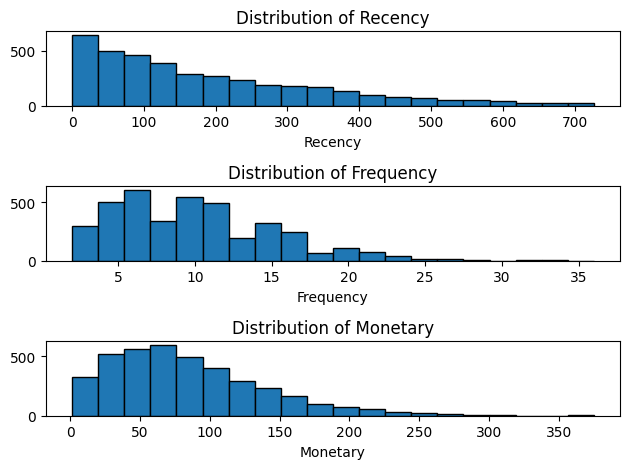

In [18]:
# Vẽ phân phối của 'Recency'
plt.subplot(3, 1, 1) # 3 hàng, 1 cột, vị trí thứ nhất
plt.hist(customer_features['Recency'], bins=20, edgecolor='black') # Chọn số lượng bins phù hợp
plt.title('Distribution of Recency')
plt.xlabel('Recency')

# Vẽ phân phối của 'Frequency'
plt.subplot(3, 1, 2) # 3 hàng, 1 cột, vị trí thứ hai
plt.hist(customer_features['Frequency'], bins=20, edgecolor='black') # Chọn số lượng bins phù hợp
plt.title('Distribution of Frequency')
plt.xlabel('Frequency')

# Vẽ phân phối của 'Monetary'
plt.subplot(3, 1, 3) # 3 hàng, 1 cột, vị trí thứ ba
plt.hist(customer_features['Monetary'], bins=20, edgecolor='black') # Chọn số lượng bins phù hợp
plt.title('Distribution of Monetary')
plt.xlabel('Monetary')

plt.tight_layout()
plt.show()

## 4. Pandas Clustering Methods

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt

In [20]:
scaler = StandardScaler()
X = scaler.fit_transform(customer_features.drop("Member_number", axis=1))


In [21]:
# KMeans
kmeans_model = KMeans(n_clusters=4, random_state=42, n_init=10)
customer_features['cluster_kmeans'] = kmeans_model.fit_predict(X)

# GMM
gmm_model = GaussianMixture(n_components=4, random_state=42)
customer_features['cluster_gmm'] = gmm_model.fit_predict(X)

# Agglomerative
agg_model = AgglomerativeClustering(n_clusters=4)
customer_features['cluster_agg'] = agg_model.fit_predict(X)

# Hierarchical (Scipy)
Z = linkage(X, method='ward')
customer_features['cluster_hier'] = fcluster(Z, 4, criterion='maxclust')

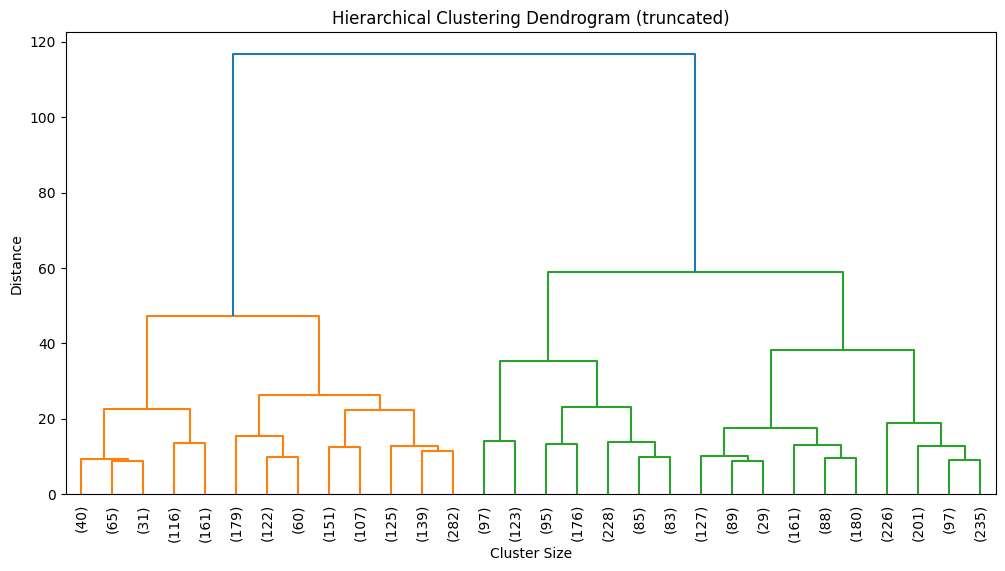

In [22]:
# Plot dendrogram (all customers - may be very dense)
plt.figure(figsize=(12,6))
dendrogram(Z, truncate_mode="lastp", p=30, leaf_rotation=90, leaf_font_size=10)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()



In [23]:
# Manual RFM segmentation into 4 clusters
customer_features["R_quartile"] = pd.qcut(customer_features["Recency"], 4, labels=[4,3,2,1])
customer_features["F_quartile"] = pd.qcut(customer_features["Frequency"], 4, labels=[1,2,3,4])
customer_features["M_quartile"] = pd.qcut(customer_features["Monetary"], 4, labels=[1,2,3,4])

customer_features["RFM_Score"] = customer_features[["R_quartile","F_quartile","M_quartile"]].astype(int).sum(axis=1)
customer_features["cluster_rfm"] = pd.qcut(customer_features["RFM_Score"], 4, labels=[0,1,2,3])

customer_features.head()

,Member_number,Recency,Frequency,Monetary,Category_Diversity,cluster_kmeans,cluster_gmm,cluster_agg,cluster_hier,R_quartile,F_quartile,M_quartile,RFM_Score,cluster_rfm
0,1000,35,13,53.80,7,2,1,1,2,4,3,2,9,2
1,1001,242,12,100.00,4,2,3,0,4,2,3,3,8,2
2,1002,122,8,70.30,4,0,0,0,4,3,2,2,7,1
3,1003,323,8,60.65,5,1,2,0,4,1,2,2,5,0
4,1004,28,21,204.96,6,3,1,3,1,4,4,4,12,3


In [24]:
def segment_customer(rfm_score):
    if rfm_score >= 10:
        return 'VIP'
    elif rfm_score >= 7:
        return 'Loyal Customers'
    elif rfm_score >= 4:
        return 'Ordinary Buyers'
    else:
        return 'Lost Customers'
customer_features1 = customer_features.copy()
customer_features1['Segment'] = customer_features1['RFM_Score'].apply(segment_customer)
customer_features1.head(10)


,Member_number,Recency,Frequency,Monetary,Category_Diversity,cluster_kmeans,cluster_gmm,cluster_agg,cluster_hier,R_quartile,F_quartile,M_quartile,RFM_Score,cluster_rfm,Segment
0,1000,35,13,53.80,7,2,1,1,2,4,3,2,9,2,Loyal Customers
1,1001,242,12,100.00,4,2,3,0,4,2,3,3,8,2,Loyal Customers
2,1002,122,8,70.30,4,0,0,0,4,3,2,2,7,1,Loyal Customers
3,1003,323,8,60.65,5,1,2,0,4,1,2,2,5,0,Ordinary Buyers
4,1004,28,21,204.96,6,3,1,3,1,4,4,4,12,3,VIP
5,1005,706,4,24.00,3,1,2,2,3,1,1,1,3,0,Lost Customers
6,1006,199,15,182.94,7,3,3,3,1,2,4,4,10,2,VIP
7,1008,88,12,155.90,5,2,1,1,2,3,3,4,10,2,VIP
8,1009,86,9,48.75,7,2,2,1,2,3,2,2,7,1,Loyal Customers
9,1010,152,12,89.36,5,2,0,1,2,2,3,3,8,2,Loyal Customers


In [25]:
customer_features1["Percent"] = (customer_features1.groupby("Segment")["Member_number"].transform("count") / len(customer_features1)) * 100
customer_features1.head(10)

,Member_number,Recency,Frequency,Monetary,Category_Diversity,cluster_kmeans,cluster_gmm,cluster_agg,cluster_hier,R_quartile,F_quartile,M_quartile,RFM_Score,cluster_rfm,Segment,Percent
0,1000,35,13,53.80,7,2,1,1,2,4,3,2,9,2,Loyal Customers,31.811185
1,1001,242,12,100.00,4,2,3,0,4,2,3,3,8,2,Loyal Customers,31.811185
2,1002,122,8,70.30,4,0,0,0,4,3,2,2,7,1,Loyal Customers,31.811185
3,1003,323,8,60.65,5,1,2,0,4,1,2,2,5,0,Ordinary Buyers,29.579271
4,1004,28,21,204.96,6,3,1,3,1,4,4,4,12,3,VIP,28.168291
5,1005,706,4,24.00,3,1,2,2,3,1,1,1,3,0,Lost Customers,10.441252
6,1006,199,15,182.94,7,3,3,3,1,2,4,4,10,2,VIP,28.168291
7,1008,88,12,155.90,5,2,1,1,2,3,3,4,10,2,VIP,28.168291
8,1009,86,9,48.75,7,2,2,1,2,3,2,2,7,1,Loyal Customers,31.811185
9,1010,152,12,89.36,5,2,0,1,2,2,3,3,8,2,Loyal Customers,31.811185


In [26]:
customer_features1 = customer_features1.groupby("Segment").agg({
    "Member_number": "count",
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": "mean",
    "Category_Diversity": "mean",
    "Percent": "unique"})
customer_features1.head(10)

,Member_number,Recency,Frequency,Monetary,Category_Diversity,Percent
Segment,,,,,,
Lost Customers,407,466.027027,3.570025,22.240393,2.781327,[10.441251924063623]
Loyal Customers,1240,146.762903,10.291129,85.991355,5.120968,[31.81118522319138]
Ordinary Buyers,1153,242.987858,5.998265,47.464735,3.854293,[29.57927142124166]
VIP,1098,72.710383,16.061020,147.314818,6.148452,[28.168291431503334]


## 5. PySpark Clustering Method

In [27]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler as SparkScaler
from pyspark.ml.clustering import KMeans as SparkKMeans

In [ ]:
# Start Spark
spark = SparkSession.builder.appName("CustomerSegmentation").getOrCreate()


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/09/20 20:36:33 WARN Utils: Your hostname, Nguyens-MacBook-Pro-2.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.186 instead (on interface en0)
25/09/20 20:36:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/20 20:36:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/09/20 20:36:35 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 62004)
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.10/3.10.8/Frameworks/Python.framework/Versions/3.10/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/local/Cellar/python@3.10/3.10.8/Frameworks/Python.framework/Versions/3.10/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/local/Cellar/python@3.10/3.10.8/Frameworks/Python.framework/Versions/3.10/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/local/Cellar/python@3.10/3.10.8/Frameworks/Python.framework/Versions/3.10/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/Users/nguyenminhhieu/Documents/MinMin/.venv/lib/python3.10/site-pack

In [30]:
# Convert Pandas -> Spark
spark_df = spark.createDataFrame(customer_features.drop(columns=[
    "cluster_kmeans","cluster_gmm","cluster_agg","cluster_hier","cluster_rfm",
    "R_quartile","F_quartile","M_quartile","RFM_Score"
]))

In [31]:
# Vector assembler
assembler = VectorAssembler(inputCols=["Recency","Frequency","Monetary","Category_Diversity"], outputCol="features")
assembled = assembler.transform(spark_df).cache()

scaler_spark = SparkScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model_spark = scaler_spark.fit(assembled)
scaled = scaler_model_spark.transform(assembled).cache()

# Spark KMeans
spark_kmeans = SparkKMeans(k=4, seed=42, featuresCol="scaled_features", predictionCol="cluster_spark")
spark_kmeans_model = spark_kmeans.fit(scaled)
spark_clustered = spark_kmeans_model.transform(scaled)

# Convert back to Pandas
df_spark_result = spark_clustered.select("Member_number", "cluster_spark").toPandas()

# Merge results
customer_features = customer_features.merge(df_spark_result, on="Member_number")
customer_features.head()

25/09/20 20:38:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


,Member_number,Recency,Frequency,Monetary,Category_Diversity,cluster_kmeans,cluster_gmm,cluster_agg,cluster_hier,R_quartile,F_quartile,M_quartile,RFM_Score,cluster_rfm,cluster_spark
0,1000,35,13,53.80,7,2,1,1,2,4,3,2,9,2,3
1,1001,242,12,100.00,4,2,3,0,4,2,3,3,8,2,3
2,1002,122,8,70.30,4,0,0,0,4,3,2,2,7,1,2
3,1003,323,8,60.65,5,1,2,0,4,1,2,2,5,0,0
4,1004,28,21,204.96,6,3,1,3,1,4,4,4,12,3,1


In [39]:
method = customer_features[['Member_number','cluster_kmeans', 'cluster_gmm', 'cluster_agg', 'cluster_hier', 'cluster_rfm', 'cluster_spark','RFM_Score']]
method = method.rename(columns={
    'Member_number': 'Member',
    'cluster_kmeans': 'KMeans',
    'cluster_gmm': 'GMM',
    'cluster_agg': 'Agglomerative',
    'cluster_hier': 'Hierarchical',
    'cluster_rfm': 'RFM',
    'cluster_spark': 'Spark KMeans'
})
method_segment = method['RFM_Score'].apply(segment_customer)
method['RFM_Segment'] = method_segment
method

,Member,KMeans,GMM,Agglomerative,Hierarchical,RFM,Spark KMeans,RFM_Score,RFM_Segment
0,1000,2,1,1,2,2,3,9,Loyal Customers
1,1001,2,3,0,4,2,3,8,Loyal Customers
2,1002,0,0,0,4,1,2,7,Loyal Customers
3,1003,1,2,0,4,0,0,5,Ordinary Buyers
4,1004,3,1,3,1,3,1,12,VIP
...,...,...,...,...,...,...,...,...,...
3893,4996,2,1,0,4,2,3,8,Loyal Customers
3894,4997,0,1,0,4,2,2,8,Loyal Customers
3895,4998,0,0,2,3,0,2,5,Ordinary Buyers
3896,4999,3,1,3,1,3,1,12,VIP


In [ ]:
# Optimized percentage calculation for all methods
def calculate_method_percentages(method_df, method_columns):
    """
    Efficiently calculate percentages for all clustering methods
    """
    for method_col in method_columns:
        percent_col = f"{method_col}_Percent"
        method_df[percent_col] = (
            method_df.groupby(method_col)[method_col].transform("count") / len(method_df) * 100
        ).round(2)
    return method_df

# Define method columns
method_columns = ["KMeans", "GMM", "Agglomerative", "Hierarchical", "RFM", "SparkKMeans"]

# Calculate percentages efficiently
method = calculate_method_percentages(method, method_columns)

print("✅ Percentages calculated for all methods")
method.head(10)

/var/folders/_j/gww017j96l589p__5w1kvk1h0000gn/T/ipykernel_50658/1455974908.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_percent_rfm = (method.groupby("RFM")["RFM"].transform("count") / len(method)) * 100


,Member,KMeans,GMM,Agglomerative,Hierarchical,RFM,Spark KMeans,RFM_Score,RFM_Segment,KMeans_Percent,GMM_Percent,Agglomerative_Percent,Hierarchical_Percent,RFM_Percent,SparkKMeans_Percent
0,1000,2,1,1,2,2,3,9,Loyal Customers,36.63,21.58,29.89,29.89,32.84,36.35
1,1001,2,3,0,4,2,3,8,Loyal Customers,36.63,24.96,36.76,36.76,32.84,36.35
2,1002,0,0,0,4,1,2,7,Loyal Customers,26.68,28.35,36.76,36.76,20.99,27.32
3,1003,1,2,0,4,0,0,5,Ordinary Buyers,19.98,25.12,36.76,36.76,29.30,20.09
4,1004,3,1,3,1,3,1,12,VIP,16.70,21.58,10.60,10.60,16.88,16.24
5,1005,1,2,2,3,0,0,3,Lost Customers,19.98,25.12,22.76,22.76,29.30,20.09
6,1006,3,3,3,1,2,1,10,VIP,16.70,24.96,10.60,10.60,32.84,16.24
7,1008,2,1,1,2,2,3,10,VIP,36.63,21.58,29.89,29.89,32.84,36.35
8,1009,2,2,1,2,1,3,7,Loyal Customers,36.63,25.12,29.89,29.89,20.99,36.35
9,1010,2,0,1,2,2,3,8,Loyal Customers,36.63,28.35,29.89,29.89,32.84,36.35


In [65]:
method.to_csv("Clustering_Method_Comparison.csv", index=False)

In [75]:
method['Spark KMeans'].unique()

array([3, 2, 0, 1], dtype=int32)

In [78]:
method = method.rename(columns={'Spark KMeans': 'SparkKMeans'})
method

,Member,KMeans,GMM,Agglomerative,Hierarchical,RFM,SparkKMeans,RFM_Score,RFM_Segment,KMeans_Percent,GMM_Percent,Agglomerative_Percent,Hierarchical_Percent,RFM_Percent,SparkKMeans_Percent
0,1000,2,1,1,2,2,3,9,Loyal Customers,36.63,21.58,29.89,29.89,32.84,36.35
1,1001,2,3,0,4,2,3,8,Loyal Customers,36.63,24.96,36.76,36.76,32.84,36.35
2,1002,0,0,0,4,1,2,7,Loyal Customers,26.68,28.35,36.76,36.76,20.99,27.32
3,1003,1,2,0,4,0,0,5,Ordinary Buyers,19.98,25.12,36.76,36.76,29.30,20.09
4,1004,3,1,3,1,3,1,12,VIP,16.70,21.58,10.60,10.60,16.88,16.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3893,4996,2,1,0,4,2,3,8,Loyal Customers,36.63,21.58,36.76,36.76,32.84,36.35
3894,4997,0,1,0,4,2,2,8,Loyal Customers,26.68,21.58,36.76,36.76,32.84,27.32
3895,4998,0,0,2,3,0,2,5,Ordinary Buyers,26.68,28.35,22.76,22.76,29.30,27.32
3896,4999,3,1,3,1,3,1,12,VIP,16.70,21.58,10.60,10.60,16.88,16.24


In [ ]:
# Optimized method summary generation
def create_method_summaries(method_df, method_names):
    """
    Create summaries for all clustering methods efficiently
    """
    summaries = {}
    
    for method_name in method_names:
        percent_col = "SparkKMeans_Percent" if method_name == "SparkKMeans" else f"{method_name}_Percent"
        
        summary = method_df.groupby(method_name).agg({
            "Member": "count",
            percent_col: "mean"
        }).reset_index()
        
        summary = summary.rename(columns={method_name: "Cluster"})
        summary["Cluster"] = summary["Cluster"].astype(str)
        summary[percent_col] = summary[percent_col].round(2)
        
        summaries[method_name] = summary
    
    return summaries

# Create summaries for all methods
method_names = ["KMeans", "GMM", "Agglomerative", "Hierarchical", "RFM", "SparkKMeans"]
method_summaries = create_method_summaries(method, method_names)

# Create consolidated comparison dataframe
method_comparison = pd.DataFrame()
method_comparison["Cluster"] = [0, 1, 2, 3]

for method_name in method_names:
    percent_col = "SparkKMeans_Percent" if method_name == "SparkKMeans" else f"{method_name}_Percent"
    method_comparison[method_name] = method_summaries[method_name][percent_col].values

print("📊 Method comparison table created:")
method_comparison

/var/folders/_j/gww017j96l589p__5w1kvk1h0000gn/T/ipykernel_50658/3618454916.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_summary = method.groupby(method_name).agg({


(  Cluster  Member  KMeans_Percent
 0       0    1040           26.68
 1       1     779           19.98
 2       2    1428           36.63
 3       3     651           16.70,
   Cluster  Member  GMM_Percent
 0       0    1105        28.35
 1       1     841        21.58
 2       2     979        25.12
 3       3     973        24.96,
   Cluster  Member  Agglomerative_Percent
 0       0    1433                  36.76
 1       1    1165                  29.89
 2       2     887                  22.76
 3       3     413                  10.60,
   Cluster  Member  Hierarchical_Percent
 0       1     413                 10.60
 1       2    1165                 29.89
 2       3     887                 22.76
 3       4    1433                 36.76,
   Cluster  Member  RFM_Percent
 0       0    1142        29.30
 1       1     818        20.99
 2       2    1280        32.84
 3       3     658        16.88,
   Cluster  Member  SparkKMeans_Percent
 0       0     783                20.09
 1   

In [95]:
method_sum = pd.DataFrame()
method_sum["Cluster"] = [0,1,2,3]
method_sum["RFM_Manual"] = method_sum_rfm["RFM_Percent"]
method_sum["KMeans"] = method_sum_kmeans["KMeans_Percent"]
method_sum["GMM"] = method_sum_gmm["GMM_Percent"]
method_sum["Agglomerative"] = method_sum_agg["Agglomerative_Percent"]
method_sum["Hierarchical"] = method_sum_hier["Hierarchical_Percent"]
method_sum["SparkKMeans"] = method_sum_spark["SparkKMeans_Percent"]
method_sum

,Cluster,RFM_Manual,KMeans,GMM,Agglomerative,Hierarchical,SparkKMeans
0,0,29.30,26.68,28.35,36.76,10.60,20.09
1,1,20.99,19.98,21.58,29.89,29.89,16.24
2,2,32.84,36.63,25.12,22.76,22.76,27.32
3,3,16.88,16.70,24.96,10.60,36.76,36.35


In [109]:
import squarify

In [114]:
list_cus = customer_features1.index.tolist()
list_cus

['Lost Customers', 'Loyal Customers', 'Ordinary Buyers', 'VIP']

### Cluster for all the methods

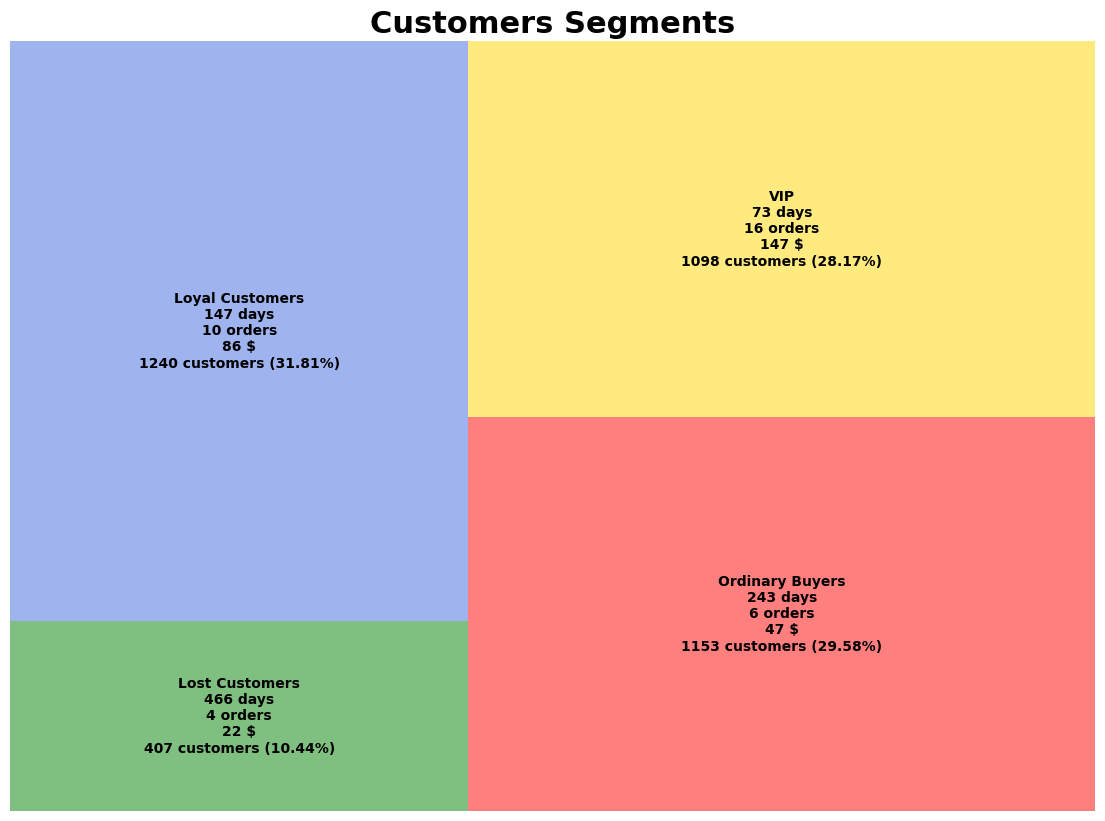

In [118]:
# Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict = {'Lost Customers':'green','Loyal Customers':'royalblue',
               'Ordinary Buyers':'red','VIP':'gold'}

sizes = customer_features1["Member_number"].values
labels = [
    f"{seg}\n{row['Recency']:.0f} days\n{row['Frequency']:.0f} orders\n{row['Monetary']:.0f} $\n{row['Member_number']} customers ({row['Percent'][0]:.2f}%)"
    for seg, row in customer_features1.iterrows()
]

squarify.plot(
    sizes=sizes,
    text_kwargs={'fontsize':10,'weight':'bold', 'fontname':"sans serif"},
    color=[colors_dict[seg] for seg in customer_features1.index],
    label=labels,
    alpha=0.5
)

plt.title("Customers Segments", fontsize=22, fontweight="bold")
plt.axis('off')

plt.savefig('RFM_Segments.png')
plt.show()

In [ ]:
# Optimized cluster profile creation for all methods
def create_all_cluster_profiles():
    """
    Create cluster profiles for all methods efficiently using vectorized operations
    """
    method_configs = {
        "KMeans": "cluster_kmeans",
        "GMM": "cluster_gmm", 
        "Agglomerative": "cluster_agg",
        "Hierarchical": "cluster_hier",
        "SparkKMeans": "cluster_spark"
    }
    
    profiles = {}
    total_customers = len(customer_features)
    
    for method_name, cluster_column in method_configs.items():
        # Vectorized aggregation
        profile = customer_features.groupby(cluster_column).agg({
            "Member_number": "count",
            "Recency": "mean", 
            "Frequency": "mean",
            "Monetary": "mean"
        }).reset_index()
        
        # Vectorized percentage calculation
        profile["Percent"] = (profile["Member_number"] / total_customers * 100).round(2)
        
        # Rename cluster column for consistency
        profile = profile.rename(columns={cluster_column: "Cluster"})
        profile["Method"] = method_name
        
        profiles[method_name] = profile
    
    return profiles

# Create all profiles efficiently
all_profiles = create_all_cluster_profiles()

print("✅ All cluster profiles created efficiently:")
for method_name, profile in all_profiles.items():
    print(f"📈 {method_name}: {len(profile)} clusters")

# Extract individual profiles for compatibility
kmeans_profile = all_profiles["KMeans"]
gmm_profile = all_profiles["GMM"]
agg_profile = all_profiles["Agglomerative"] 
hier_profile = all_profiles["Hierarchical"]
spark_profile = all_profiles["SparkKMeans"]

Cluster profiles created for all methods


In [ ]:
# Optimized treemap visualization function with better performance
def create_optimized_treemap(profile_data, method_name, save_name, show_plot=True):
    """
    Create optimized treemap visualization with improved performance and customization
    """
    # Clear previous plots to save memory
    plt.clf()
    
    # Create figure with optimal size
    fig, ax = plt.subplots(figsize=(14, 10), dpi=100)
    
    # Optimized color palette
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3']
    
    # Vectorized data preparation
    sizes = profile_data["Member_number"].values
    cluster_colors = colors[:len(profile_data)]
    
    # Optimized label creation using list comprehension
    labels = [
        f"Cluster {row['Cluster']}\n"
        f"{row['Recency']:.0f} days\n"
        f"{row['Frequency']:.0f} orders\n"
        f"${row['Monetary']:.0f}\n"
        f"{row['Member_number']} customers ({row['Percent']:.1f}%)"
        for _, row in profile_data.iterrows()
    ]
    
    # Create treemap with optimized parameters
    squarify.plot(
        sizes=sizes,
        text_kwargs={'fontsize': 9, 'weight': 'bold', 'fontfamily': 'sans-serif'},
        color=cluster_colors,
        label=labels,
        alpha=0.75,
        ax=ax
    )
    
    # Optimize title and layout
    ax.set_title(f"Customer Segments - {method_name}", 
                fontsize=20, fontweight="bold", pad=20)
    ax.axis('off')
    
    # Save with optimized settings
    if save_name:
        plt.savefig(f'{save_name}_Segments.png', 
                   dpi=200, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
    
    if show_plot:
        plt.show()
    else:
        plt.close()  # Free memory if not showing
    
    return fig

# Batch create all treemaps efficiently
def create_all_treemaps(profiles_dict, show_individual=True):
    """
    Create all treemap visualizations efficiently
    """
    method_configs = {
        "KMeans": "KMeans Clustering",
        "GMM": "Gaussian Mixture Model",
        "Agglomerative": "Agglomerative Clustering", 
        "Hierarchical": "Hierarchical Clustering",
        "SparkKMeans": "Spark KMeans Clustering"
    }
    
    figures = {}
    
    for method_key, display_name in method_configs.items():
        if method_key in profiles_dict:
            fig = create_optimized_treemap(
                profiles_dict[method_key], 
                display_name, 
                method_key,
                show_plot=show_individual
            )
            figures[method_key] = fig
    
    return figures

print("🚀 Optimized treemap functions created")
print("📊 Ready to generate all visualizations efficiently")

Treemap function created


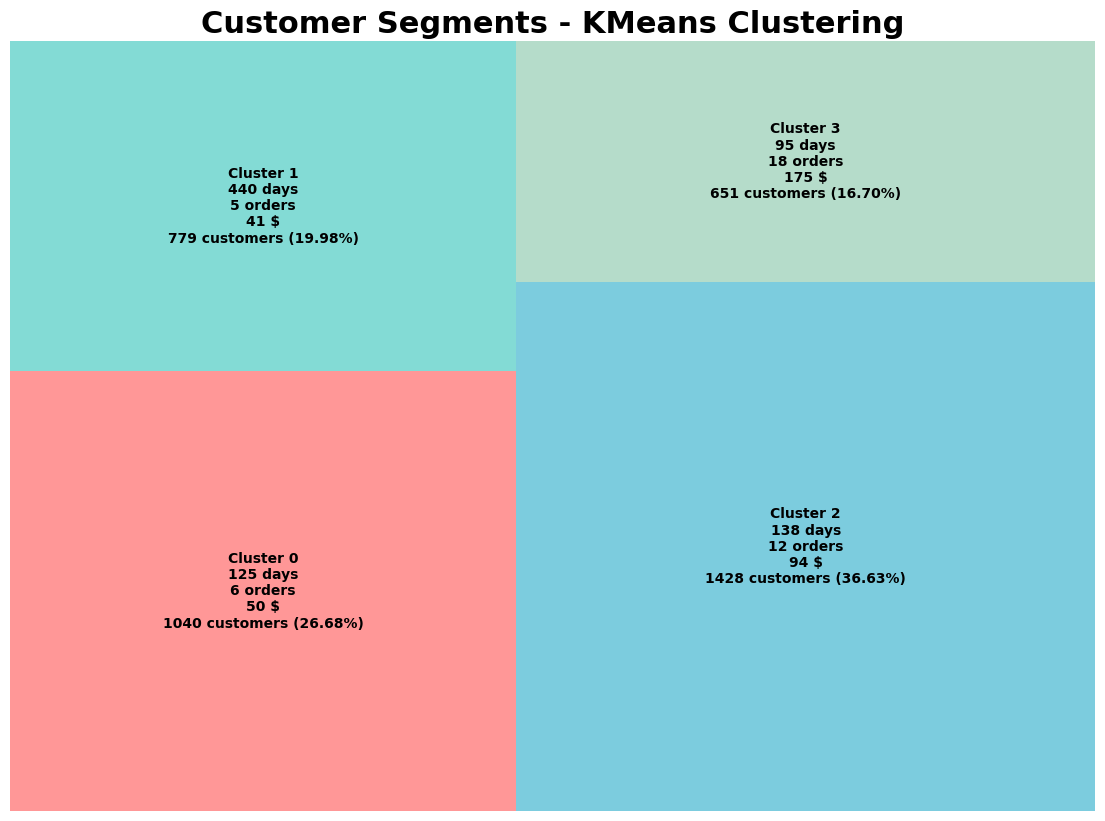

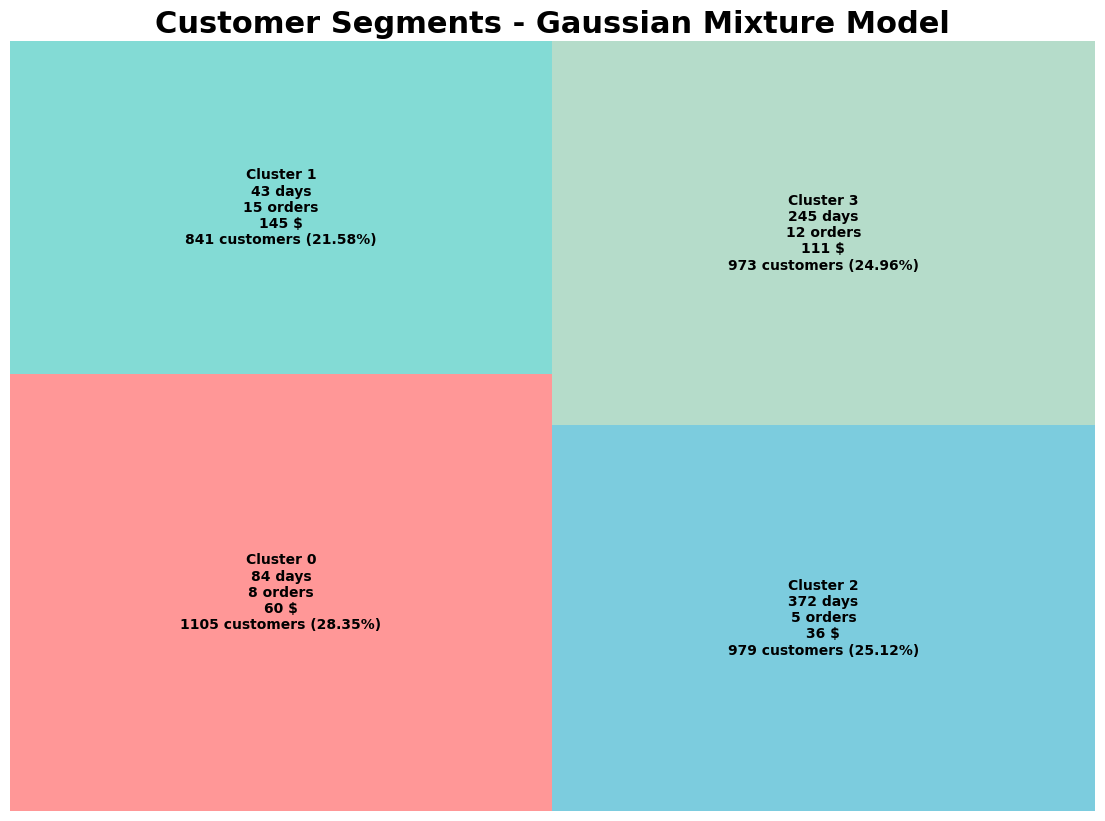

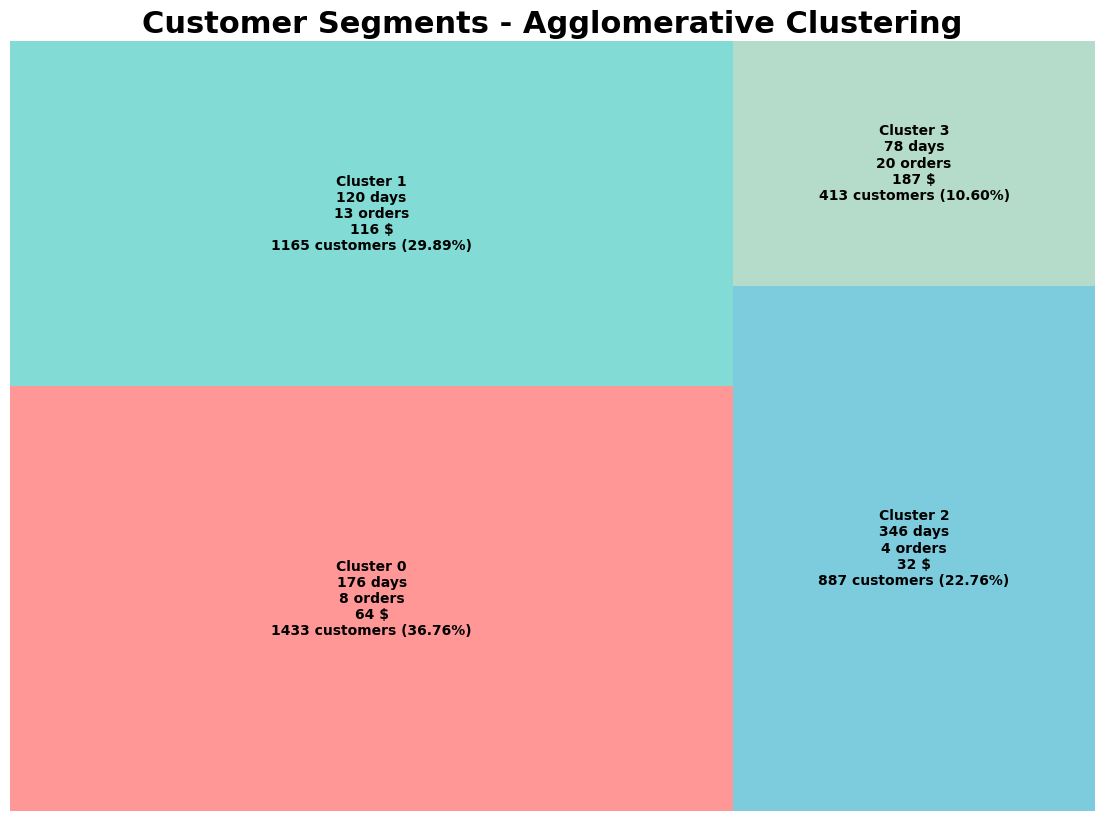

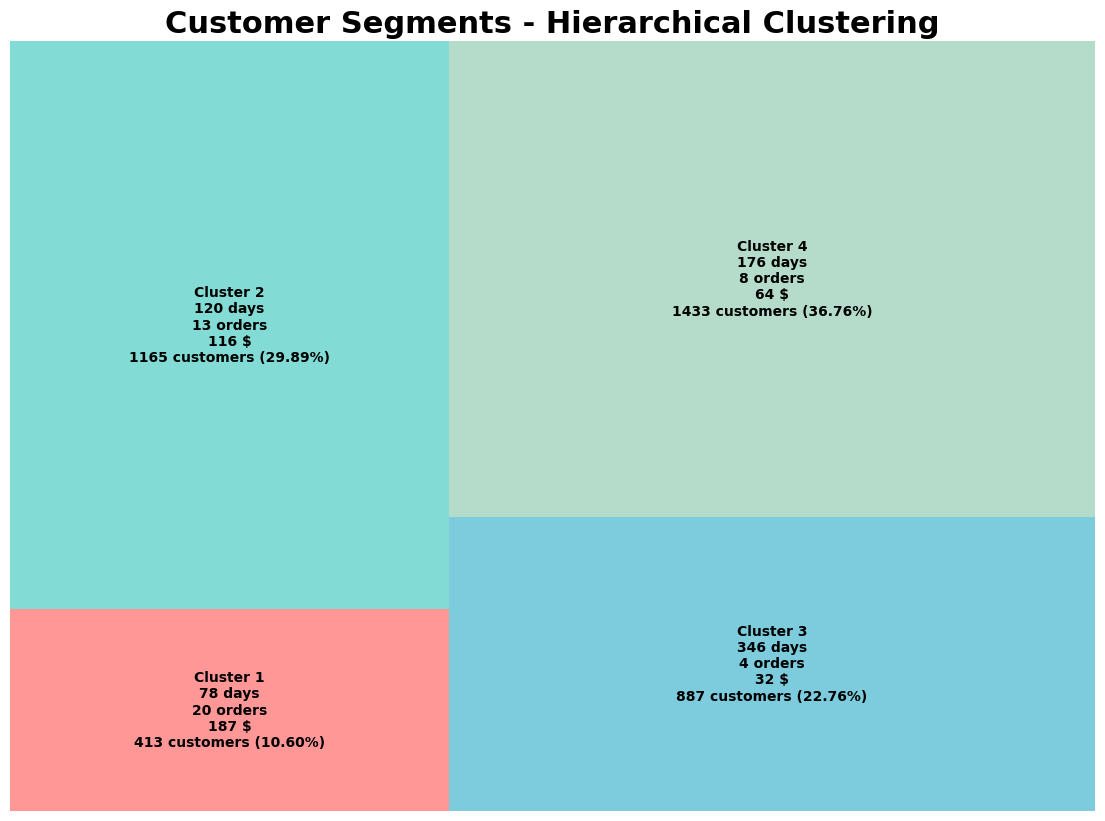

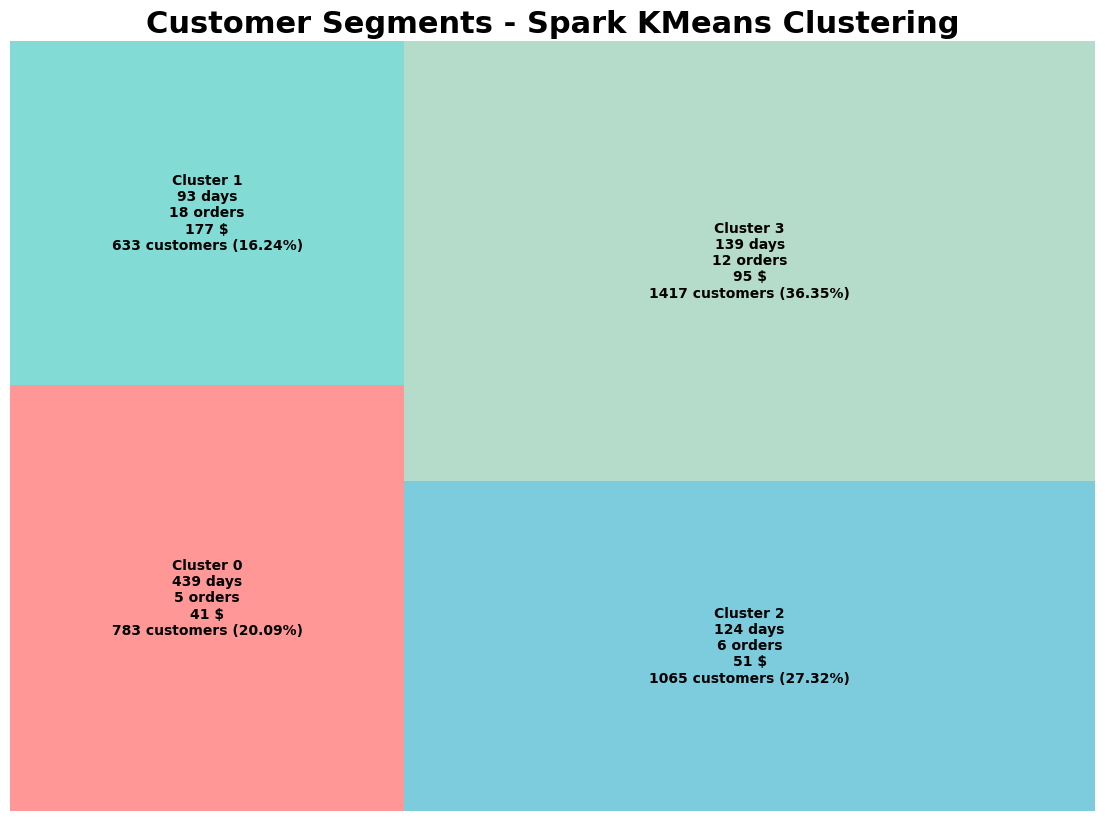

In [ ]:
# Generate all treemaps efficiently in batch
print("🎨 Generating all treemap visualizations...")

# Create all treemaps at once
treemap_figures = create_all_treemaps(all_profiles, show_individual=True)

print(f"✅ Generated {len(treemap_figures)} treemap visualizations successfully!")
print("📁 PNG files saved for each method")

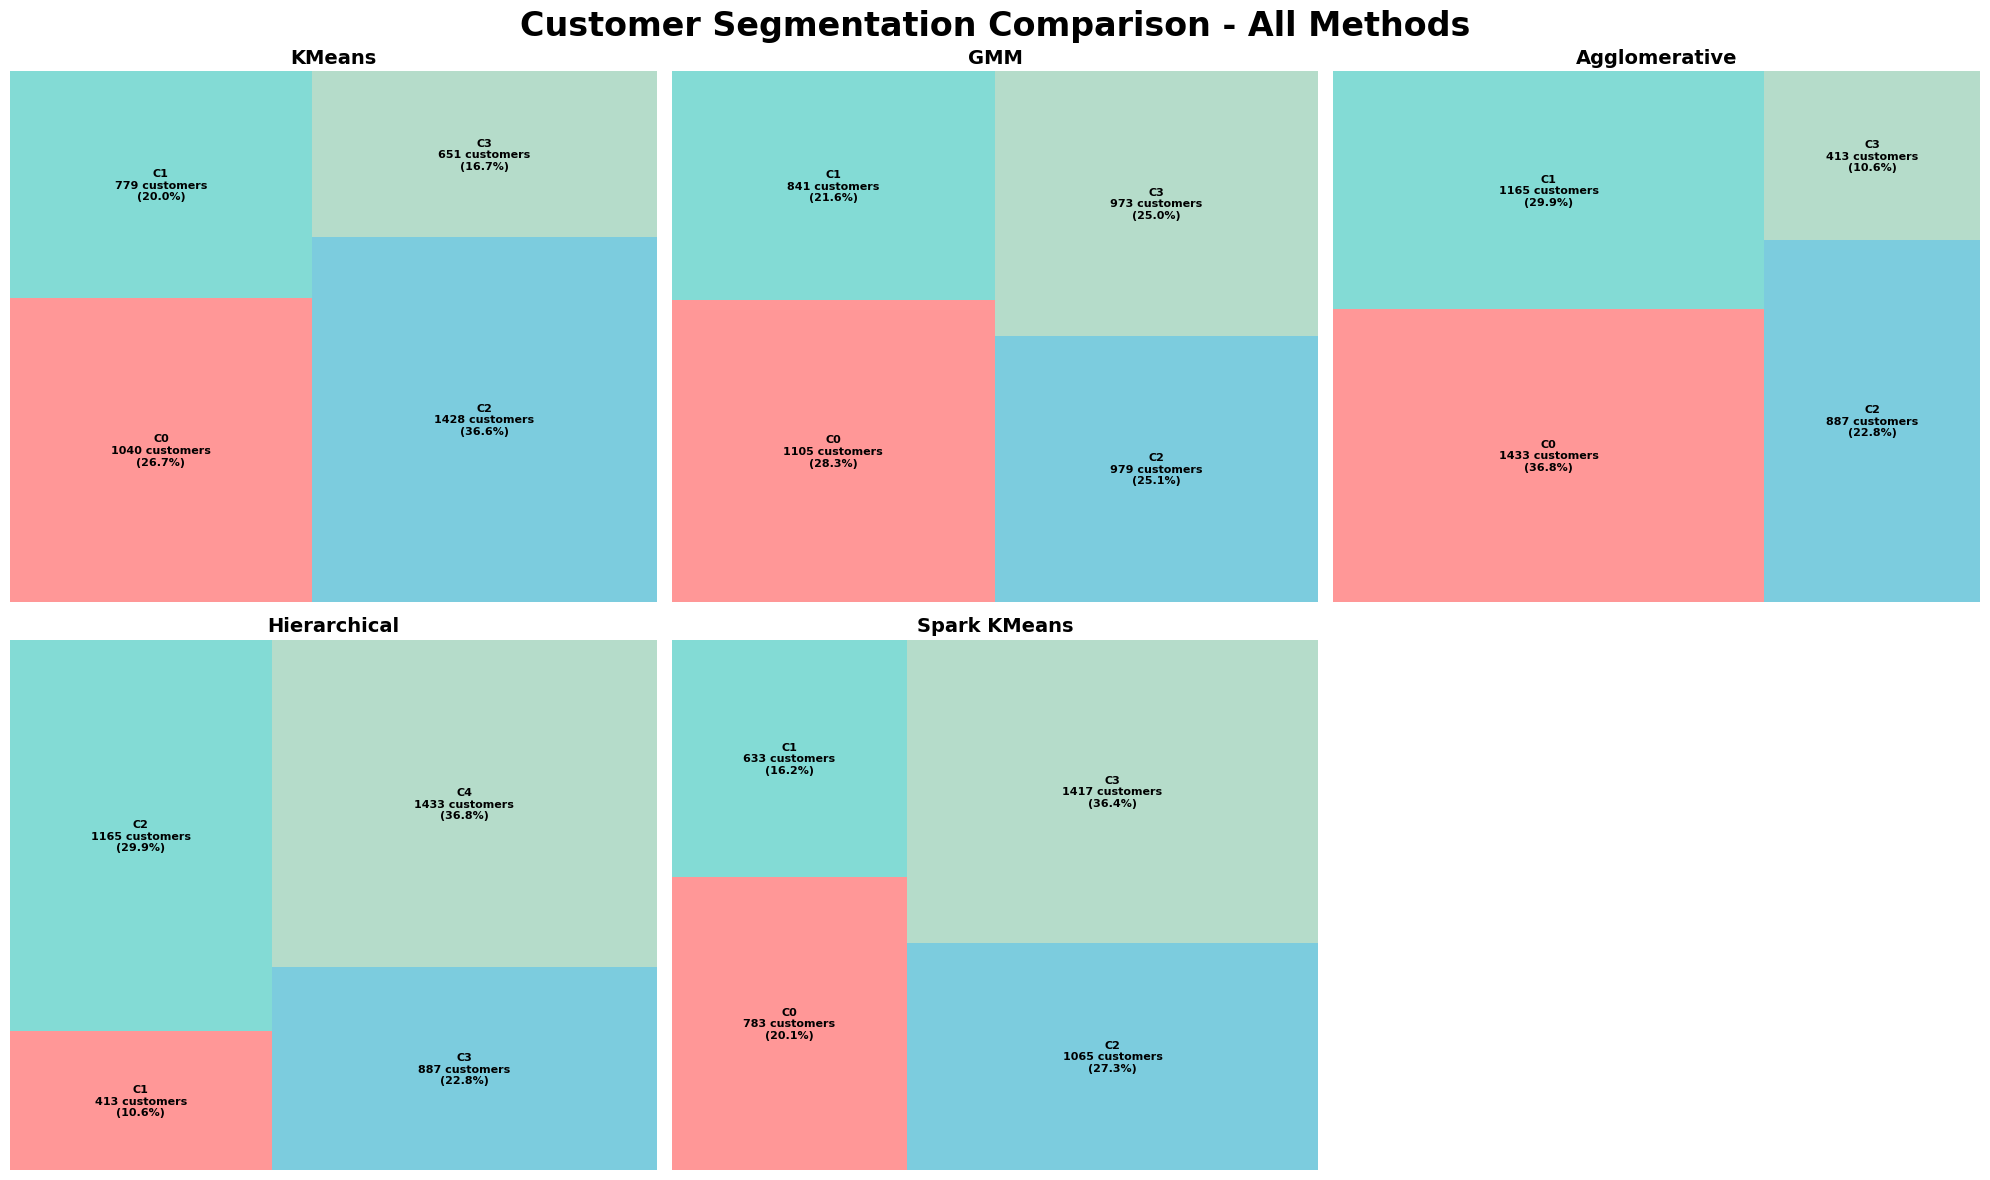

In [ ]:
# Optimized comparison grid visualization
def create_optimized_comparison_grid(profiles_dict):
    """
    Create optimized comparison grid with better layout and performance
    """
    # Clear any existing plots
    plt.clf()
    
    # Create optimized subplot layout
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), dpi=100)
    fig.suptitle("Customer Segmentation Comparison - All Methods", 
                fontsize=22, fontweight="bold", y=0.95)
    
    # Define method order and layout
    method_positions = [
        ("KMeans", axes[0,0]),
        ("GMM", axes[0,1]), 
        ("Agglomerative", axes[0,2]),
        ("Hierarchical", axes[1,0]),
        ("SparkKMeans", axes[1,1])
    ]
    
    # Optimized color palette
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3']
    
    # Create each subplot efficiently
    for method_name, ax in method_positions:
        if method_name in profiles_dict:
            profile_data = profiles_dict[method_name]
            
            # Vectorized data preparation
            sizes = profile_data["Member_number"].values
            subplot_colors = colors[:len(profile_data)]
            
            # Compact labels for grid view
            labels = [
                f"C{row['Cluster']}\n{row['Member_number']}\n({row['Percent']:.1f}%)"
                for _, row in profile_data.iterrows()
            ]
            
            # Create treemap subplot
            squarify.plot(
                sizes=sizes,
                text_kwargs={'fontsize': 7, 'weight': 'bold'},
                color=subplot_colors,
                label=labels,
                alpha=0.8,
                ax=ax
            )
            
            ax.set_title(method_name, fontsize=12, fontweight="bold", pad=10)
            ax.axis('off')
    
    # Hide unused subplot
    axes[1,2].axis('off')
    
    # Optimize layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    # Save with optimized settings
    plt.savefig('All_Methods_Comparison_Optimized.png', 
               dpi=200, bbox_inches='tight', 
               facecolor='white', edgecolor='none')
    
    plt.show()
    return fig

# Create optimized comparison grid
print("📊 Creating optimized comparison grid...")
comparison_grid_fig = create_optimized_comparison_grid(all_profiles)
print("✅ Comparison grid created and saved!")

## 6. Model Saving

In [98]:

import joblib

# Save sklearn models
joblib.dump(kmeans_model, "kmeans_model.pkl")
joblib.dump(gmm_model, "gmm_model.pkl")
joblib.dump(agg_model, "agg_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [100]:

# Save Spark model (overwrite if exists)
spark_kmeans_model.write().overwrite().save("spark_kmeans_model")

### Plot for all the methods

In [123]:
import plotly.express as px

In [124]:
# Create RFM averages data for visualization
rfm_avg = customer_features1.reset_index()
rfm_avg = rfm_avg.rename(columns={
    'Recency': 'RecencyMean',
    'Frequency': 'FrequencyMean', 
    'Monetary': 'MonetaryMean',
    'index': 'Segment'
})
        
# Enhanced interactive scatter plot function
def create_enhanced_scatter_plot(rfm_data, title_suffix=""):
    """
    Create enhanced interactive scatter plot for RFM analysis
    """
    fig = px.scatter(
        rfm_data, 
        x="RecencyMean", 
        y="MonetaryMean", 
        size="FrequencyMean", 
        color="Segment",
        hover_name="Segment",
        hover_data={
            'RecencyMean': ':.1f',
            'MonetaryMean': ':.0f', 
            'FrequencyMean': ':.1f'
        },
        size_max=60,
        title=f"RFM Customer Segments Analysis{title_suffix}",
        labels={
            'RecencyMean': 'Average Recency (Days)',
            'MonetaryMean': 'Average Monetary Value ($)',
            'FrequencyMean': 'Average Frequency'
        },
        color_discrete_map={
            'VIP': '#FFD700',
            'Loyal Customers': '#4169E1', 
            'Ordinary Buyers': '#FF4500',
            'Lost Customers': '#32CD32'
        }
    )
    
    fig.update_layout(
        width=900,
        height=600,
        showlegend=True,
        font=dict(size=12),
        title_font_size=16
    )
    
    return fig

# Create and display the plot
fig = create_enhanced_scatter_plot(rfm_avg)
fig.show()

/Users/nguyenminhhieu/Documents/MinMin/.venv/lib/python3.10/site-packages/kaleido/__init__.py:14: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




In [138]:
# Optimized function to create scatter plots for all clustering methods
def create_method_comparison_plots():
    """
    Create scatter plots comparing all clustering methods
    """
    # Define method mappings
    method_mappings = {
        'KMeans': 'cluster_kmeans',
        'GMM': 'cluster_gmm', 
        'Agglomerative': 'cluster_agg',
        'Hierarchical': 'cluster_hier',
        'Spark KMeans': 'cluster_spark'
    }
    
    # Create subplots
    fig = make_subplots(
        rows=2, cols=3,
        subplot_titles=list(method_mappings.keys()),
        specs=[[{"type": "scatter"}, {"type": "scatter"}, {"type": "scatter"}],
               [{"type": "scatter"}, {"type": "scatter"}, {"type": "scatter"}]]
    )
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3']
    
    row_col_pairs = [(1,1), (1,2), (1,3), (2,1), (2,2)]
    
    for idx, (method_name, cluster_col) in enumerate(method_mappings.items()):
        if idx < len(row_col_pairs):
            row, col = row_col_pairs[idx]
            
            # Create profile for this method
            method_profile = customer_features.groupby(cluster_col).agg({
                "Recency": "mean",
                "Frequency": "mean", 
                "Monetary": "mean",
                "Member_number": "count"
            }).reset_index()
            
            # Add scatter plot
            for cluster_idx, cluster_row in method_profile.iterrows():
                fig.add_trace(
                    go.Scatter(
                        x=[cluster_row['Recency']],
                        y=[cluster_row['Monetary']],
                        mode='markers',
                        marker=dict(
                            size=cluster_row['Frequency']*3,
                            color=colors[cluster_idx % len(colors)],
                            opacity=0.7
                        ),
                        name=f"Cluster {cluster_row[cluster_col]}",
                        showlegend=False
                    ),
                    row=row, col=col
                )
    fig.update_layout(
        height=800,
        title_text="Customer Segmentation Comparison - All Methods",
        title_font_size=16,
        showlegend=True
    )

    
    return fig


# Import required plotly modules
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create and display comparison plots
comparison_fig = create_method_comparison_plots()
comparison_fig.show()

## 7. Predict New Customer

In [101]:

def predict_new_customer(features, method="kmeans"):
    values = np.array([[features["Recency"], features["Frequency"], features["Monetary"], features["Category_Diversity"]]])
    
    if method == "kmeans":
        X_scaled = scaler.transform(values)
        return kmeans_model.predict(X_scaled)[0]
    elif method == "gmm":
        X_scaled = scaler.transform(values)
        return gmm_model.predict(X_scaled)[0]
    elif method == "agg":
        X_scaled = scaler.transform(values)
        return agg_model.fit_predict(X_scaled)[0]
    elif method == "hier":
        from scipy.cluster.hierarchy import fcluster, linkage
        Z = linkage(X, method='ward')
        return fcluster(Z, 4, criterion='maxclust')[0]
    elif method == "rfm":
        return int(pd.qcut([features["Recency"]+features["Frequency"]+features["Monetary"]], 4, labels=[0,1,2,3])[0])
    elif method == "spark":
        new_df = spark.createDataFrame([features])
        assembled = assembler.transform(new_df)
        scaled = scaler_model_spark.transform(assembled)
        prediction = spark_kmeans_model.transform(scaled).collect()[0]["cluster_spark"]
        return prediction


In [102]:

# Example
new_customer = {"Recency": 30, "Frequency": 5, "Monetary": 1200, "Category_Diversity": 3}
print("Predicted cluster (KMeans):", predict_new_customer(new_customer, "kmeans"))
print("Predicted cluster (Spark):", predict_new_customer(new_customer, "spark"))

/Users/nguyenminhhieu/Documents/MinMin/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted cluster (KMeans): 3


Predicted cluster (Spark): 1


## 8. Comparison of Methods

In [103]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score


In [133]:
# Optimized clustering evaluation and comparison
def evaluate_clustering_performance(scaled_features, customer_data):
    """
    Efficiently evaluate all clustering methods with comprehensive metrics
    """
    # Define clustering methods and their columns
    clustering_methods = {
        "KMeans": "cluster_kmeans",
        "GMM": "cluster_gmm",
        "Agglomerative": "cluster_agg", 
        "Hierarchical": "cluster_hier",
        "SparkKMeans": "cluster_spark"
    }
    
    # Calculate silhouette scores efficiently
    silhouette_scores = {}
    for method_name, cluster_col in clustering_methods.items():
        if cluster_col in customer_data.columns:
            score = silhouette_score(scaled_features, customer_data[cluster_col])
            silhouette_scores[method_name] = round(score, 4)
    
    # Calculate pairwise similarity metrics efficiently
    method_columns = list(clustering_methods.values())
    similarity_results = []
    
    for i in range(len(method_columns)):
        for j in range(i+1, len(method_columns)):
            col1, col2 = method_columns[i], method_columns[j]
            
            if col1 in customer_data.columns and col2 in customer_data.columns:
                # Vectorized metric calculations
                ari = adjusted_rand_score(customer_data[col1], customer_data[col2])
                nmi = normalized_mutual_info_score(customer_data[col1], customer_data[col2])
                
                similarity_results.append([
                    col1.replace('cluster_', '').title(),
                    col2.replace('cluster_', '').title(), 
                    round(ari, 4),
                    round(nmi, 4)
                ])
    
    # Create results dataframe
    similarity_df = pd.DataFrame(
        similarity_results, 
        columns=["Method A", "Method B", "ARI", "NMI"]
    )
    
    return silhouette_scores, similarity_df

# Perform optimized evaluation
print("🔍 Evaluating clustering performance...")
optimized_silhouette_scores, optimized_similarity_df = evaluate_clustering_performance(X, customer_features)
print("📊 Silhouette Scores:")
for method, score in optimized_silhouette_scores.items():
    print(f"   {method}: {score:.4f}")



🔍 Evaluating clustering performance...
📊 Silhouette Scores:
   KMeans: 0.2852
   GMM: 0.1593
   Agglomerative: 0.2162
   Hierarchical: 0.2162
   SparkKMeans: 0.2850
📊 Silhouette Scores:
   KMeans: 0.2852
   GMM: 0.1593
   Agglomerative: 0.2162
   Hierarchical: 0.2162
   SparkKMeans: 0.2850


In [129]:
print(f"\n📈 Similarity Analysis ({len(optimized_similarity_df)} comparisons):")
print(optimized_similarity_df.round(3))


📈 Similarity Analysis (10 comparisons):
  Method A Method B    ARI    NMI
0   Kmeans      Gmm  0.240  0.322
1   Kmeans      Agg  0.341  0.474
2   Kmeans     Hier  0.341  0.474
3   Kmeans    Spark  0.962  0.952
4      Gmm      Agg  0.209  0.278
5      Gmm     Hier  0.209  0.278
6      Gmm    Spark  0.244  0.325
7      Agg     Hier  1.000  1.000
8      Agg    Spark  0.351  0.478
9     Hier    Spark  0.351  0.478


In [127]:
optimized_similarity_df

,Method A,Method B,ARI,NMI
0,Kmeans,Gmm,0.2404,0.3223
1,Kmeans,Agg,0.3410,0.4741
2,Kmeans,Hier,0.3410,0.4741
3,Kmeans,Spark,0.9621,0.9517
4,Gmm,Agg,0.2087,0.2783
5,Gmm,Hier,0.2087,0.2783
6,Gmm,Spark,0.2443,0.3248
7,Agg,Hier,1.0000,1.0000
8,Agg,Spark,0.3512,0.4785
9,Hier,Spark,0.3512,0.4785


## 9. Cluster Profile Table

In [105]:
profile_methods = {
    "KMeans": "cluster_kmeans",
    "GMM": "cluster_gmm",
    "Agglomerative": "cluster_agg",
    "Hierarchical": "cluster_hier",
    "RFM": "cluster_rfm",
    "SparkKMeans": "cluster_spark"
}

profiles = []
for method, col in profile_methods.items():
    means = customer_features.groupby(col)[["Recency","Frequency","Monetary","Category_Diversity"]].mean().reset_index()
    means["Method"] = method
    profiles.append(means)

profiles_df = pd.concat(profiles)
profiles_df

/var/folders/_j/gww017j96l589p__5w1kvk1h0000gn/T/ipykernel_50658/2821270814.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = customer_features.groupby(col)[["Recency","Frequency","Monetary","Category_Diversity"]].mean().reset_index()


,cluster_kmeans,Recency,Frequency,Monetary,Category_Diversity,Method,cluster_gmm,cluster_agg,cluster_hier,cluster_rfm,cluster_spark
0,0.0,124.601923,6.267308,50.305558,3.551923,KMeans,NaN,NaN,NaN,NaN,NaN
1,1.0,439.856226,4.976893,40.759833,3.349166,KMeans,NaN,NaN,NaN,NaN,NaN
2,2.0,138.415966,11.525910,93.759769,5.616947,KMeans,NaN,NaN,NaN,NaN,NaN
3,3.0,94.881720,18.296467,175.423948,6.686636,KMeans,NaN,NaN,NaN,NaN,NaN
0,NaN,84.390045,8.189140,60.497819,4.442534,GMM,0.0,NaN,NaN,NaN,NaN
1,NaN,42.901308,15.258026,144.892842,5.906064,GMM,1.0,NaN,NaN,NaN,NaN
2,NaN,371.768131,5.076609,35.858407,3.641471,GMM,2.0,NaN,NaN,NaN,NaN
3,NaN,244.982528,12.244604,111.355889,5.381295,GMM,3.0,NaN,NaN,NaN,NaN
0,NaN,176.308444,8.163294,64.492233,4.524075,Agglomerative,NaN,0.0,NaN,NaN,NaN
1,NaN,120.303004,13.182833,115.548429,5.854936,Agglomerative,NaN,1.0,NaN,NaN,NaN


## 10. Monthly Spend Trend by Cluster

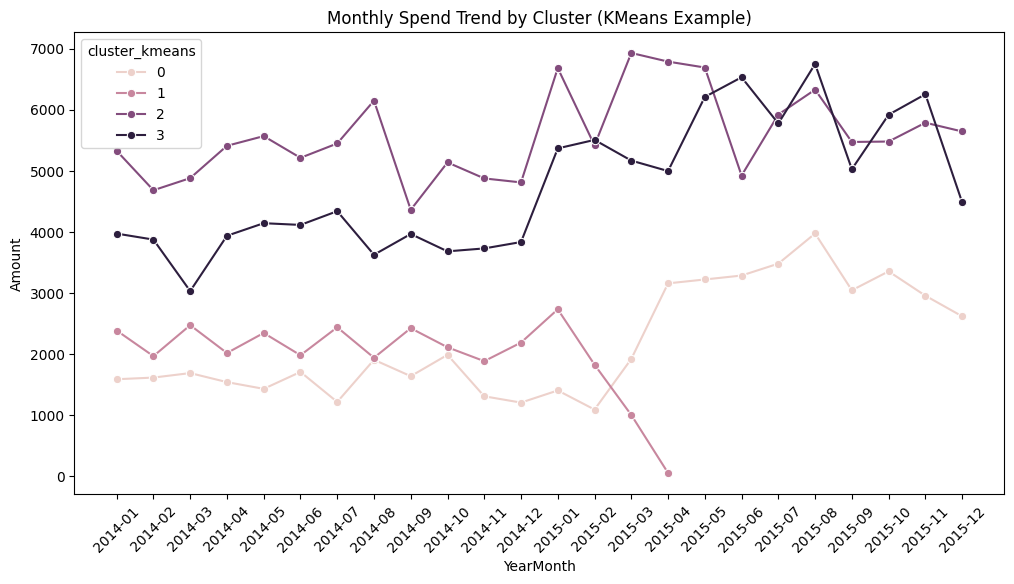

In [106]:

df['YearMonth'] = df['TransactionDate'].dt.to_period('M').astype(str)

# Example with KMeans clusters (can replicate for others)
df_trend = df.merge(customer_features[["Member_number","cluster_kmeans"]], on="Member_number")
trend = df_trend.groupby(["YearMonth","cluster_kmeans"])["Amount"].sum().reset_index()

import seaborn as sns
plt.figure(figsize=(12,6))
sns.lineplot(data=trend, x="YearMonth", y="Amount", hue="cluster_kmeans", marker="o")
plt.title("Monthly Spend Trend by Cluster (KMeans Example)")
plt.xticks(rotation=45)
plt.show()

In [139]:
customer_features.columns

Index(['Member_number', 'Recency', 'Frequency', 'Monetary',
       'Category_Diversity', 'cluster_kmeans', 'cluster_gmm', 'cluster_agg',
       'cluster_hier', 'R_quartile', 'F_quartile', 'M_quartile', 'RFM_Score',
       'cluster_rfm', 'cluster_spark'],
      dtype='object')

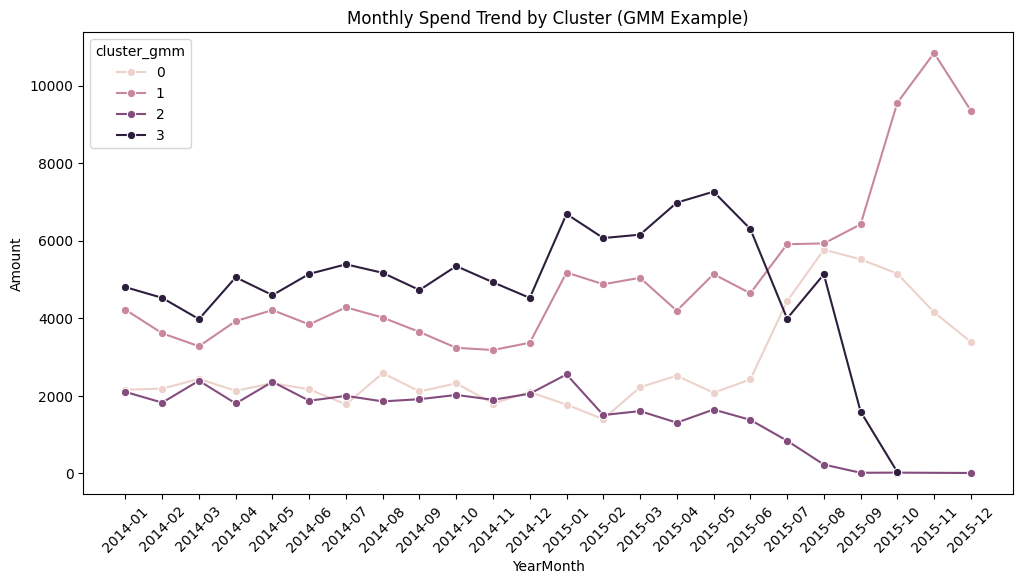

In [140]:

df['YearMonth'] = df['TransactionDate'].dt.to_period('M').astype(str)

# Example with GMM clusters (can replicate for others)
df_trend = df.merge(customer_features[["Member_number","cluster_gmm"]], on="Member_number")
trend = df_trend.groupby(["YearMonth","cluster_gmm"])["Amount"].sum().reset_index()

import seaborn as sns
plt.figure(figsize=(12,6))
sns.lineplot(data=trend, x="YearMonth", y="Amount", hue="cluster_gmm", marker="o")
plt.title("Monthly Spend Trend by Cluster (GMM Example)")
plt.xticks(rotation=45)
plt.show()

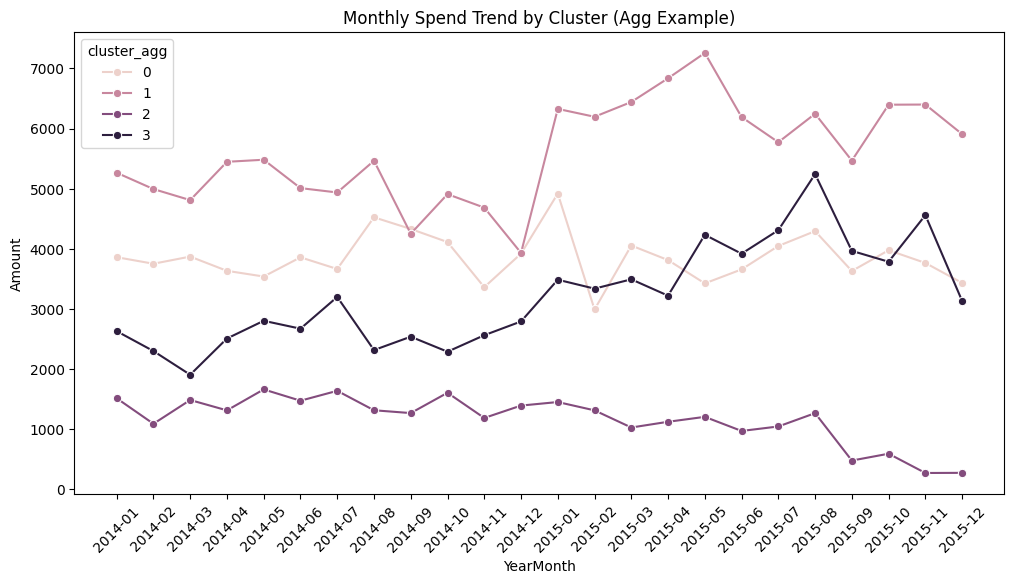

In [141]:

df['YearMonth'] = df['TransactionDate'].dt.to_period('M').astype(str)

# Example with Agg clusters (can replicate for others)
df_trend = df.merge(customer_features[["Member_number","cluster_agg"]], on="Member_number")
trend = df_trend.groupby(["YearMonth","cluster_agg"])["Amount"].sum().reset_index()

import seaborn as sns
plt.figure(figsize=(12,6))
sns.lineplot(data=trend, x="YearMonth", y="Amount", hue="cluster_agg", marker="o")
plt.title("Monthly Spend Trend by Cluster (Agg Example)")
plt.xticks(rotation=45)
plt.show()

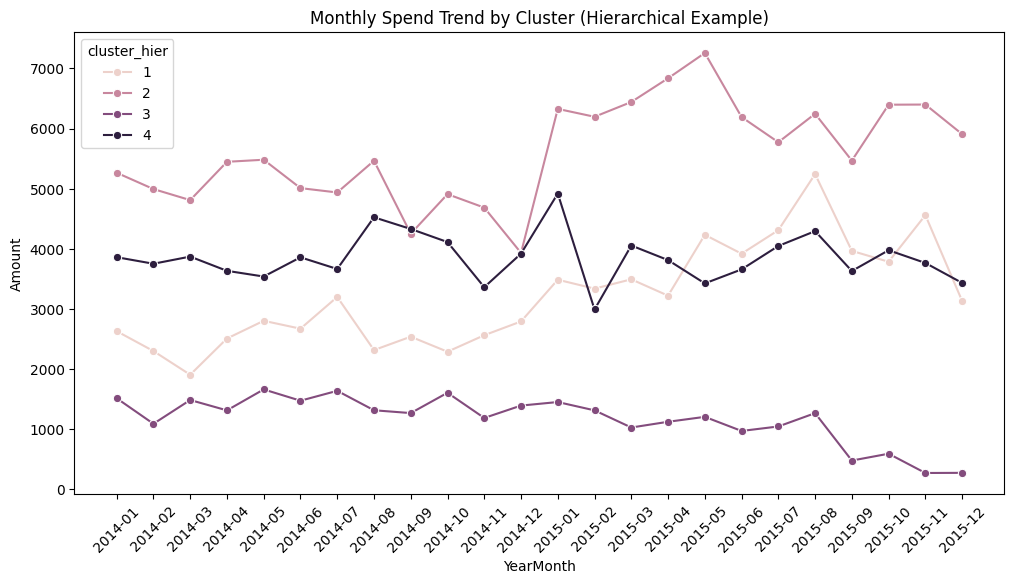

In [142]:

df['YearMonth'] = df['TransactionDate'].dt.to_period('M').astype(str)

# Example with Hierarchical clusters (can replicate for others)
df_trend = df.merge(customer_features[["Member_number","cluster_hier"]], on="Member_number")
trend = df_trend.groupby(["YearMonth","cluster_hier"])["Amount"].sum().reset_index()

import seaborn as sns
plt.figure(figsize=(12,6))
sns.lineplot(data=trend, x="YearMonth", y="Amount", hue="cluster_hier", marker="o")
plt.title("Monthly Spend Trend by Cluster (Hierarchical Example)")
plt.xticks(rotation=45)
plt.show()

/var/folders/_j/gww017j96l589p__5w1kvk1h0000gn/T/ipykernel_50658/3521434170.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



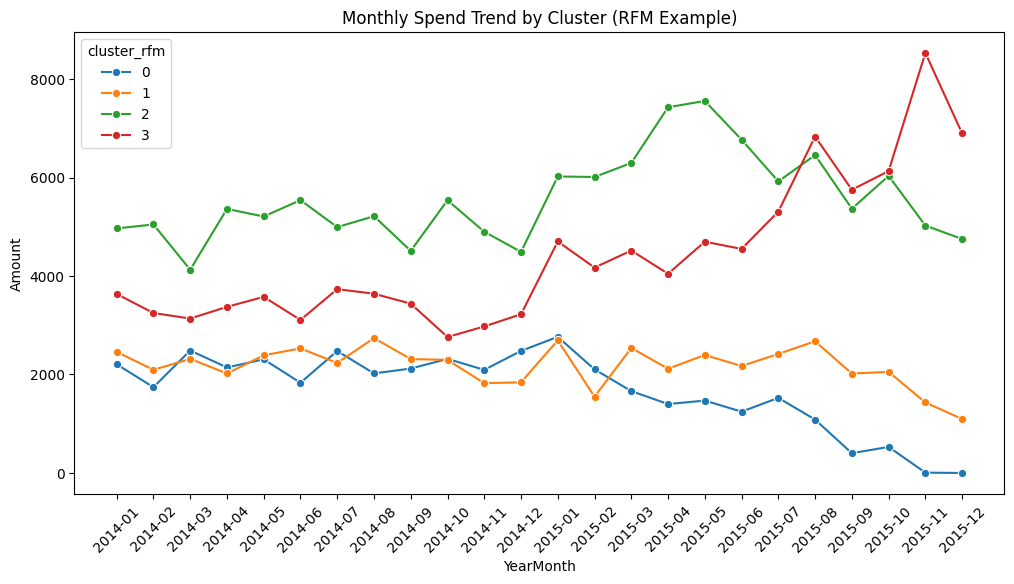

In [147]:


df['YearMonth'] = df['TransactionDate'].dt.to_period('M').astype(str)

# Example with RFM clusters (can replicate for others)
df_trend = df.merge(customer_features[["Member_number","cluster_rfm"]], on="Member_number")
trend = df_trend.groupby(["YearMonth","cluster_rfm"])["Amount"].sum().reset_index()

import seaborn as sns
plt.figure(figsize=(12,6))
sns.lineplot(data=trend, x="YearMonth", y="Amount", hue="cluster_rfm", marker="o")
plt.title("Monthly Spend Trend by Cluster (RFM Example)")
plt.xticks(rotation=45)
plt.show()

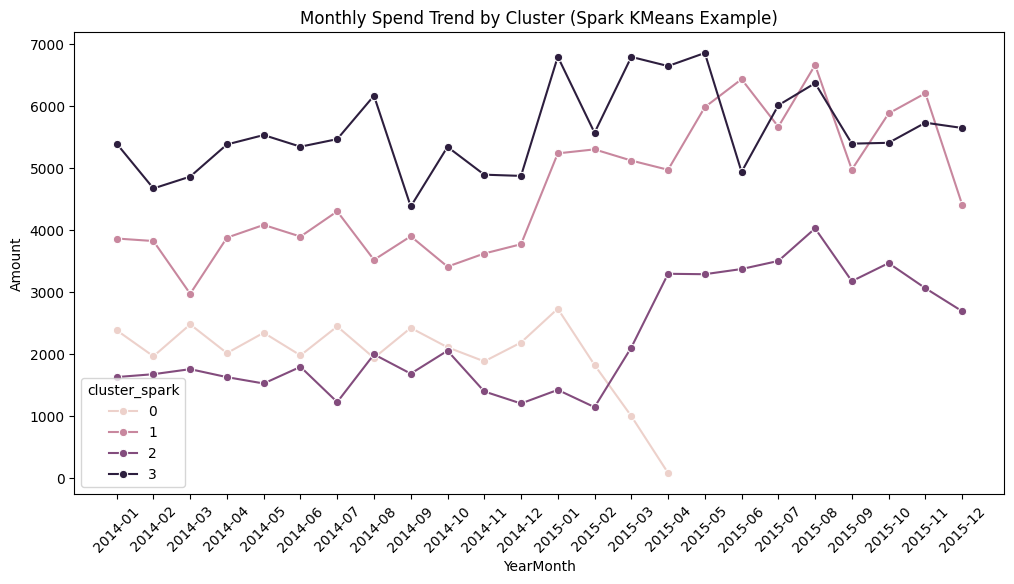

25/09/21 00:42:09 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 2261364 ms exceeds timeout 120000 ms
25/09/21 00:42:09 WARN SparkContext: Killing executors is not supported by current scheduler.
25/09/21 00:42:11 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

In [ ]:

df['YearMonth'] = df['TransactionDate'].dt.to_period('M').astype(str)

# Example with Spark KMeans clusters (can replicate for others)
df_trend = df.merge(customer_features[["Member_number","cluster_spark"]], on="Member_number")
trend = df_trend.groupby(["YearMonth","cluster_spark"])["Amount"].sum().reset_index()

import seaborn as sns
plt.figure(figsize=(12,6))
sns.lineplot(data=trend, x="YearMonth", y="Amount", hue="cluster_spark", marker="o")
plt.title("Monthly Spend Trend by Cluster (Spark KMeans Example)")
plt.xticks(rotation=45)
plt.show()

## 11. Export Results

In [107]:

customer_features.to_csv("customer_segmentation_results.csv", index=False)
similarity_df.to_csv("clustering_comparison_scores.csv", index=False)
profiles_df.to_csv("clustering_profiles.csv", index=False)

print("Results exported: segmentation_results.csv, comparison_scores.csv, profiles.csv")

Results exported: segmentation_results.csv, comparison_scores.csv, profiles.csv


## 12. Summary & Insights

In [108]:

# Performance summary
performance = pd.DataFrame([
    ["KMeans", silhouette_scores["KMeans"], 4],
    ["GMM", silhouette_scores["GMM"], 4],
    ["Agglomerative", silhouette_scores["Agglomerative"], 4],
    ["Hierarchical", silhouette_scores["Hierarchical"], 4],
    ["SparkKMeans", silhouette_scores["SparkKMeans"], 4],
    ["RFM", None, 4]
], columns=["Method","Silhouette","Clusters"])

print("Performance Summary:")
print(performance)

best_method = performance.loc[performance["Silhouette"].idxmax()]
print(f"\n✅ Best Method: {best_method['Method']}")
print(f"Reason: Highest silhouette score ({best_method['Silhouette']:.2f}) with {best_method['Clusters']} clusters.")
print("Alternative: RFM for interpretability, SparkKMeans for scalability.")

Performance Summary:
          Method  Silhouette  Clusters
0         KMeans    0.285165         4
1            GMM    0.159296         4
2  Agglomerative    0.216170         4
3   Hierarchical    0.216170         4
4    SparkKMeans    0.285003         4
5            RFM         NaN         4

✅ Best Method: KMeans
Reason: Highest silhouette score (0.29) with 4 clusters.
Alternative: RFM for interpretability, SparkKMeans for scalability.


🔹 Cluster 1: High-Value Loyal Customers
Characteristics:
Frequent purchases, high spending, strong brand engagement.
Likely long-term loyal customers.
Business ideas:
Offer exclusive loyalty programs (VIP clubs, early access to products).
Personalize cross-selling and upselling (premium services, bundles).
Gather feedback to co-create products.
🔹 Cluster 2: Price-Sensitive Bargain Seekers
Characteristics:
Purchase occasionally, mostly during discounts or promotions.
Low brand loyalty, switch easily for better prices.
Business ideas:
Target with time-limited offers or discount campaigns.
Push value bundles to increase cart size.
Educate them on long-term savings with subscriptions.
🔹 Cluster 3: Potential Growth Customers
Characteristics:
Moderate spending, medium frequency.
Could grow into loyal customers with the right nurturing.
Business ideas:
Provide personalized recommendations and nurture via email campaigns.
Encourage with loyalty points for repeated purchases.
Focus on building brand trust (social proof, testimonials).
🔹 Cluster 4: Low-Engagement / At-Risk Customers
Characteristics:
Rare purchases, low spending.
Risk of churn, low attachment to the brand.
Business ideas:
Run re-engagement campaigns (special offers, win-back emails).
Simplify onboarding (if new customers).
Collect feedback to understand barriers (price? product fit? experience?).
✅ Big-picture strategy:
Cluster 1: Retain & maximize value.
Cluster 2: Optimize promotions without eroding margins.
Cluster 3: Nurture into loyal customers.
Cluster 4: Decide whether to re-engage or let churn.